# Inverse Ising problem

This notebook gives examples of how to use the various algorithms included in ConIII for solving the inverse Ising problem. In this problem, the goal is to match the average orientation of each spin (the magnetization) $\{\langle s_{\rm i}\rangle\}$ and the pairwise correlations $\{\langle s_{\rm i} s_{\rm j}\rangle\}$ by finding the fields $\{h_{\rm i}\}$ and couplings $\{J_{\rm ij}\}$. This problem is explained in further detail in the accompanying [paper](https://github.com/eltrompetero/coniii/blob/py3/guide/guide.pdf).

## Quick guide
Each algorithm for solving the inverse Ising problem is contained in a class, an organization principle that may be familiar to users of `scikit-learn`. The algorithms are contained in the `coniii.solvers` module and based off the Solver base class. More architecture details are included in the accompanying paper.

To use an algorithm, an instance of the class must be declared and the `solve()` method called. For some of the solvers, you will also need to pass some helper functions that the algorithm needs. For the case of the pairwise maxent model, these helper functions are already part of the package, and you should be able to import them. The details for writing the particular methods you may need for your problem can be found in the references cited in the [paper](https://github.com/eltrompetero/coniii/blob/py3/guide/guide.pdf).

Most of the classes require the user to specify the maxent problem by defining `calc_observables()`. Here, "observables" refers to the constraints that are imposed in the model, and these must be calculated from some sample of states. The term "multipliers" refers to Langrangian multipliers (or parameters) that are found such that the constraints are met.

This notebook is structured such that it starts with setting up a simple $n=5$ model to solve. In this case, there are 15 parameters to find. Five parameters are the mean fields $h_{\rm i}$ corresponding to the mean orientation (magnetization) of the spins and ten parameters are for the pairwise couplings $J_{\rm ij}$ corresponding to the pairwise correlations. At the end of the notebook, we show how one can extend the package to handle higher order interactions (triplet interactions) with the MPF and MCH algorithms.

In [1]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
This section sets up an $n=5$ Ising problem to test. We define the model by choosing some random fields and couplings and sampling from the resulting distribution. This serves as an example problem where the true correlations and parameters are known and gives us a sense of how the different algorithms work on the inverse problem.

In [2]:
# Import common libraries.
from coniii import *
# Import file containing full equations for solving the n=5 system
from coniii.ising_eqn import ising_eqn_5_sym

# Define common functions.
calc_e, calc_observables, mchApproximation = define_ising_helper_functions()

# Generate example data set.
n = 5  # system size
np.random.seed(0)  # standardize random seed
h = np.random.normal(scale=.1, size=n)           # random couplings
J = np.random.normal(scale=.1, size=n*(n-1)//2)  # random fields
hJ = np.concatenate((h, J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact means and pairwise correlations

allstates = bin_states(n, True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),
                                    size=100,
                                    replace=True,
                                    p=p)]  # random sample from p(s)
sisj = pair_corr(sample, concat=True)  # means and pairwise correlations

def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJ - estMultipliers )

# Enumeration

The Enumerate class implements the most direct approach to solving the inverse Ising problem by writing out all the constraint equations. This involves enumerating all the terms in the partition function $Z$. Then, we find the solution using `scipy.optimize.minimize` which is contained in the `Enumerate.solve()` method.
<br><br><br>
Using the Enumerate class consists of a few steps.
1. Use `enumerate.py` helper module to write the equations corresponding to the system of interest. All pairwise Ising systems from sizes $n=2$ up to $n=9$ are already included in the `coniii.ising_eqn` module. To write the equations for the $n=5$ Ising model that we use an example in this notebook, you first navigate to the installation directory in the site-package directory (this can be found by running `import coniii` and then `coniii.__path__`). Then, run in the terminal,<br><br>
`python enumerate.py 5 1`
<br>
The first argument to `enumerate.py` is the system size and the 1 indicates that the equations should be written for the symmetric Ising model $\sigma_{\rm i}\in\{-1,1\}$. For $\sigma_{\rm i}\in \{0,1\}$, we would put a 0 instead. The naming convention is "ising\_eqn\_[n][s].py" where n is the system size and "\_sym" is the suffix if the spins are symmetric. Some more details are in the \_\_main\_\_ block at the bottom of `enumerate.py`. Note that file size grows exponentially with the size of the system!


3. Define the function for calculating the observables (usually the mean of each spin and pairwise correlations) using the parameters (Langrangian multipliers). This will be passed into `calc_observables_multipliers`.<br><br>
2. Use the Enumerate class to solve the equations written in the resulting file.

As a test of the Enumerate class below, we show that fitting to the known values of $\langle\sigma_{\rm i}\rangle$ and $\langle\sigma_{\rm i}\sigma_{\rm j}\rangle$ recovers the exact values of the parameters. Unfortunately, this approach scales very poorly (exponentially in memory and time) for large systems.<br><br>
### Notes:
- It is much more efficient computationally to solve the asymmetric binary system $\sigma_{\rm i}\in \{0,1\}$. We suggest transforming your problem into the \{0,1\} basis.

In [3]:
# Define function specifically needed for creating Enumerate class.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers. For
    the Ising model, these are the means of each spin and the pairwise correlations.
    """
    E = calc_e(allstates, J)
    return pair_corr( allstates, np.exp(-E-logsumexp(-E)), concat=True )

# Declare and call solver.
# For this example, we show that numerically exact results can be found when the exact 
# correlations are given. In general, exact correlations are not known and they must be 
# estimated from the data.
solver = Enumerate(n,
                   calc_observables_multipliers=calc_observables_multipliers,
                   calc_observables=calc_observables)
estMultipliers = solver.solve(constraints=sisjTrue, fsolve_kwargs={})

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print("Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

Error on multipliers: 1.448606E-08
Error on sample corr: 4.023216E-01


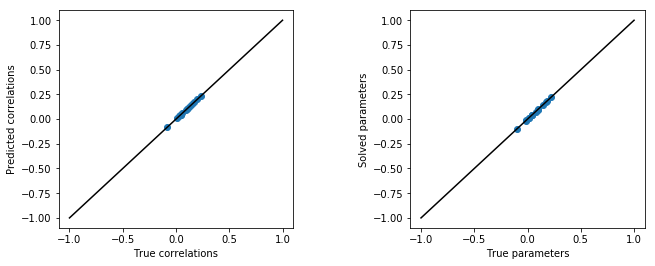

In [4]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisjTrue, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='True correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Minimum probability flow (MPF)
MPF involves minimizing a much simpler objective function. One component that is necessary is the connectivity matrix defining which states are connected to each other such that probability can flow between them. This is defined in the `adj()` function for the Ising model.

MPF is easily generalizable to arbitrary constraints by modifying `calc_observables()`.

MPF is not expected to return the exact solution, but usually the estimated parameters are quite close to the ones calculated using MCH (shown below) while running faster. Note that MPF is given a finite sample from the true distribution to solve for, so we do not expect that it recover the same parameters, but it matches the correlations quite closely as measured with MCMC sampling.

In [5]:
# Declare and call solver.
# adj() was imported from coniii.utils at the beginning. It is a function for finding all 
# the neighbors of a given state and is necessary for the MPF algorithm (called g_ij in 
# Sohl-Dickstein 2011).
solver = MPF(n, 
             calc_observables=calc_observables,
             adj=adj)
estMultipliers = solver.solve(sample)

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print("Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

Error on multipliers: 5.202323E-01
Error on sample corr: 2.128157E-02


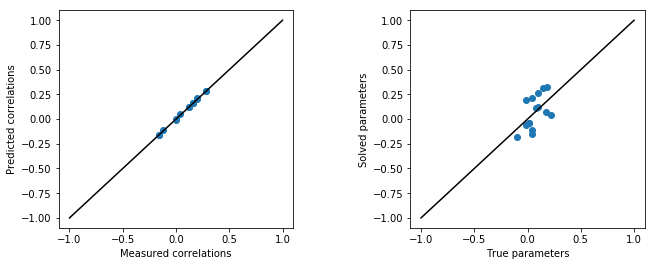

In [6]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood
Pseudollikelihood requires calculating the conditional probability for a single spin given the rest of the system  
>$p_{\rm r}=\left.p(\sigma_{\rm r}\right|\sigma\backslash\sigma_{\rm r})$.

As a result, there is no guarantee that pseudolikelihood comes close to the solution, but it usually does quite well as shown below.

The Pseudo class is written specifically for the pairwise Ising model. It requires that the user define a function `get_multipliers_r()` that retrieves the parameters from the parameters vector relevant for calculating $p_{\rm r}$ and `calc_observables_r()` that calculates $p_{\rm r}$ from a sample of states. Template functions that work for the Ising model are defined in `utils.define_pseudo_ising_helpers()`.<br><br>

## Notes
- The coupling matrix is constrained to be symmetric in the code below $J_{\rm ij}=J_{\rm ji}$.

In [7]:
get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n)

solver = Pseudo(n,
                calc_observables=calc_observables,
                calc_observables_r=calc_observables_r,
                get_multipliers_r=get_multipliers_r)
estMultipliers = solver.solve(sample, zeros(15))

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print("Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

Error on multipliers: 5.188541E-01
Error on sample corr: 4.040665E-03


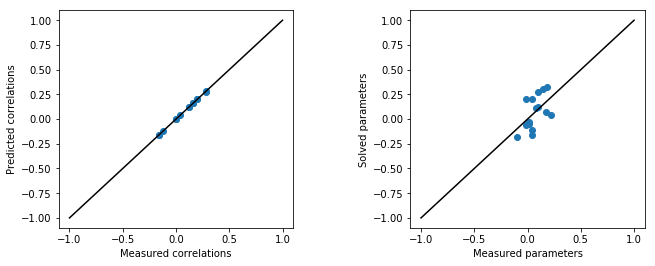

In [8]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='Measured parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Adaptive cluster expansion
Cluster expansion can be made to get arbitrarily close to matching the measured correlations exactly but at the cost of increased run time.

Cluster expansion is written specifically for the pairwise Ising model. The user must specify a threshold that determines when the algorithm stops. A lower threshold will return a more accurate answer, but will also take longer to run.

In [9]:
solver = ClusterExpansion(n, calc_observables=calc_observables)

threshold = 0.001
estMultipliers = solver.solve(sample, threshold)

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print("Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

adaptiveClusterExpansion: Clusters of size 2
adaptiveClusterExpansion: Clusters of size 3
adaptiveClusterExpansion: Clusters of size 4
Error on multipliers: 4.914205E-01
Error on sample corr: 6.567170E-02


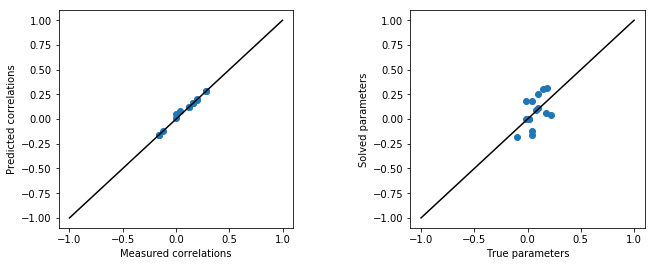

In [10]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Monte Carlo histogram (MCH)
MCH is easily generalizable to any maxent problem.

MCH loops a sampling step for approximating the distribution with the current set of multipliers and then a run of the MCH approximation step on that sample. This method is the slow because of the time required for sampling from  $p(\sigma)$ and requires fine tuning to adjust the learning rule. The algorithm can get arbitrarily close to matching the measured correlations, but at the expense of runtime as specified in the accompanying paper.

The user must define how to perform the MCH approximation step for the problem at hand. The Ising model is already implemented in mchApproximation. The user must specify parameters for the sampling routine and the learning rule.
These can be modified during the run by passing in a function for the keyword `custom_convergence_f()`.

The size of the sample will determine how accurately the algorithm can converge to the answer. Roughly speaking, you can expect your sampling error for each estimated correlation to scale as $1/\sqrt{K}$ where $K$ is your sample size.

In [11]:
# Setting n_cpus=1 turns of parallelization with the multiprocess module which can be faster 
# because of overhead associated with initializing multiple threads.
solver = MCH(n,
             calc_observables=calc_observables,
             sample_size=100,
             sample_method='ising_metropolis',
             mch_approximation=mchApproximation,
             n_cpus=1)

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Run solver.
estMultipliers, errflag, errs = solver.solve(constraints=sisj,
                                             maxiter=40,
                                             custom_convergence_f=learn_settings,
                                             full_output=True)

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print( "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

/Users/eddie/anaconda/envs/python36/lib/python3.6/site-packages/coniii/solvers.py:680: UserWarning: Number of burn in MCMC iterations between samples may be too small for convergence to stationary distribution.
  "convergence to stationary distribution.")
/Users/eddie/anaconda/envs/python36/lib/python3.6/site-packages/coniii/solvers.py:683: UserWarning: Number of MCMC iterations between samples may be too small for convergence to stationary distribution.
  "stationary distribution.")


Error on multipliers: 5.521202E-01
Error on sample corr: 1.218740E-01


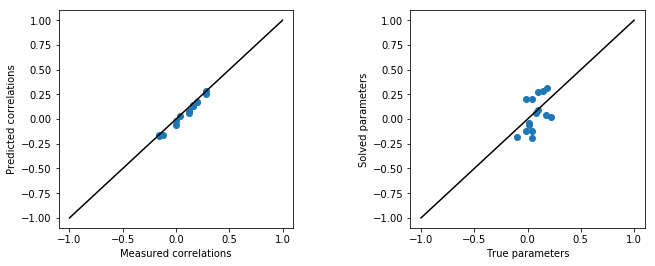

In [12]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Regularized mean field
RMF is specific to the pairwise Ising model.

RMF is an analytic mean-field approximation in which the magnitude of couplings are regularized.  The strength of the regularization $\gamma$ is found by maximum likelihood as estimated from MC sampling. Thus, we typically expect this approach to do match the correlations worse when the regularization is stronger as can be seen below.

In [13]:
solver = RegularizedMeanField(n, calc_observables=calc_observables)
estMultipliers = solver.solve(sample, sample_size=100)

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print("Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

coocSampleCovariance : WARNING : using ad-hoc 'Laplace' correction


/Users/eddie/anaconda/envs/python36/lib/python3.6/site-packages/coniii/mean_field_ising.py:135: ComplexWarning: Casting complex values to real discards the imaginary part
  J[iFull,jFull] = Jcluster[i,j]


Error on multipliers: 7.257372E-01
Error on sample corr: 5.931506E-01


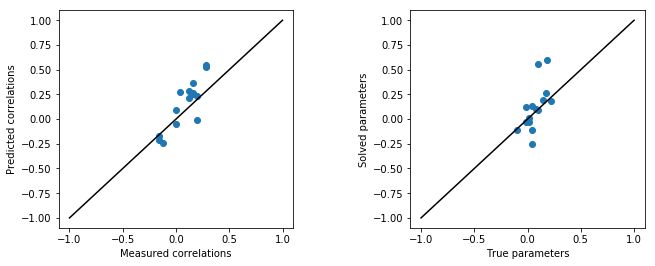

In [14]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Triplet order model

The pairwise Ising model can be extended to include interactions between triplets of spins denoted by $K_{\rm ijk}$  
$\displaystyle E(\{s_{\rm i}\}) = -\sum_{\rm i<j<k} K_{\rm ijk} s_{\rm i} s_{\rm j} s_{\rm k} -\sum_{\rm i<j}J_{\rm ij}s_{\rm i}s_{\rm j} -\sum_{\rm i}^Nh_{\rm i}$
<br><br>

# MPF (triplets)
We give an example of MPF extended to this triplet interaction model.

In [15]:
from coniii.ising_eqn import ising_eqn_5_sym_triplet as ising

@njit
def calc_observables(X):
    """Triplet order model consists of constraining all the correlations up to third order."""
    
    n = X.shape[1]
    Y = np.zeros((len(X), n+n*(n-1)//2+n*(n-1)*(n-2)//6))
    
    # average orientation (magnetization)
    counter = 0
    for i in range(n):
        Y[:,counter] = X[:,i]
        counter += 1
    
    # pairwise correlations
    for i in range(n-1):
        for j in range(i+1, n):
            Y[:,counter] = X[:,i]*X[:,j]
            counter += 1
            
    # triplet correlations
    for i in range(n-2):
        for j in range(i+1, n-1):
            for k in range(j+1, n):
                Y[:,counter] = X[:,i]*X[:,j]*X[:,k]
                counter += 1
    return Y

# Generate example data set.
np.random.seed(1)  # standardize random seed
h = np.random.normal(scale=.1, size=n)  # random fields
J = np.random.normal(scale=.1, size=n*(n-1)//2)  # couplings
K = np.random.normal(scale=.05, size=n*(n-1)*(n-2)//6)  # triplet interactions
hJK = np.concatenate((h, J, K))
p = ising.p(hJK)  # probability distribution of all states p(s)
sisjTrue = ising.calc_observables(hJK)  # exact means and pairwise correlations

allstates = bin_states(n, True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),
                                    size=1000,
                                    replace=True,
                                    p=p)]  # random sample from p(s)
sisj = calc_observables(sample).mean(0)  # means and pairwise correlations

def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJ - estMultipliers )

In [16]:
# Declare and call solver.
# adj() was imported from coniii.utils at the beginning. It is a function for finding all 
# the neighbors of a given state and is necessary for the MPF algorithm (called g_ij in 
# Sohl-Dickstein 2011).
solver = MPF(n, 
             calc_observables=calc_observables,
             adj=adj)
estMultipliers = solver.solve(sample)

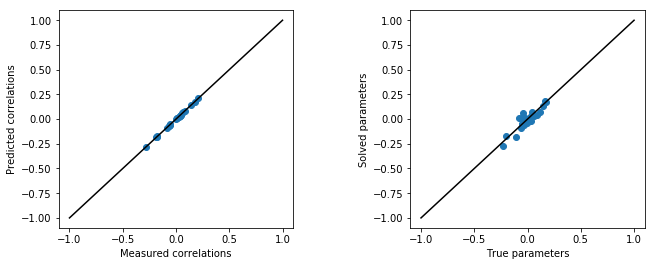

In [17]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJK, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# MCH (triplets)

In [18]:
# Redefine mch_approximation to handle triplet interactions. This involves changing lines 5 and
# 7 to account for the triplet interactions and correlations.
def mch_approximation( samples, dlamda ):
        """Function for making MCH approximation step for Ising model."""
        dE = calc_observables(samples).dot(dlamda)
        ZFraction = len(dE) / np.exp(logsumexp(-dE))
        predsisj = ( calc_observables( samples )*np.exp(-dE)[:,None] ).mean(0) * ZFraction  
        assert not (np.any(predsisj<-1.00000001) or
            np.any(predsisj>1.000000001)),"Predicted values are beyond limits, (%1.6f,%1.6f)"%(predsisj.min(),
                                                                                               predsisj.max())
        return predsisj

solver = MCH(n,
             calc_observables=calc_observables,
             sample_size=100,
             sample_method='metropolis',
             mch_approximation=mch_approximation)

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Run solver.
estMultipliers, errflag, errs = solver.solve(constraints=sisj,
                                             maxiter=50,
                                             burnin=100,
                                             n_iters=30,
                                             custom_convergence_f=learn_settings,
                                             full_output=True)

print("Error on multipliers: %E"%np.linalg.norm(hJK-estMultipliers))
print( "Error on sample corr: %E"%error_on_correlations(ising.calc_observables(estMultipliers)))

/Users/eddie/anaconda/envs/python36/lib/python3.6/site-packages/coniii/solvers.py:683: UserWarning: Number of MCMC iterations between samples may be too small for convergence to stationary distribution.
  "stationary distribution.")


Error on multipliers: 2.100131E-01
Error on sample corr: 7.472533E-02


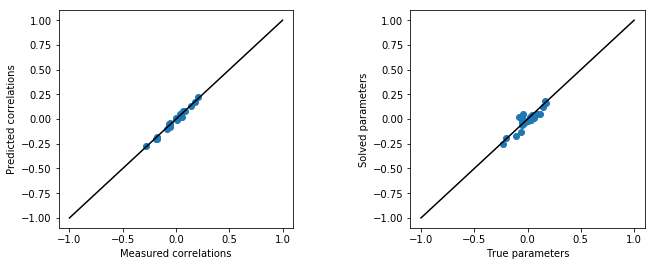

In [19]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJK, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)